# Preprocessing

In [548]:
import pandas as pd
import numpy as np
import pprint as pp
import graphviz as gv

In [549]:
df = pd.read_csv('dane.csv')
df

,Nr,Miasto,Czas dojazdu samochodem,Liczba ludności,Średnia temperatura w lipcu,Liczba deszczowych dni w lipcu,Zanieczyszczenia powietrza [**],Zanieczyszczenia powietrza
0,1,Białystok,5 godzin 6 minut,293413,19.5,10,111,5
1,2,Bydgoszcz,1 godzina 58 minut,337666,19.4,9,104,5
2,3,Gdańsk,3 godziny 46 minut,486022,18.9,10,114,5
3,4,Poznań,57 minut,546859,19.8,9,106,5
4,5,Katowice,3 godziny 34 minuty,289162,19.5,11,14,1
5,6,Kielce,4 godziny 6 minut,192498,19.4,10,44,2
6,7,Kraków,4 godziny 25 minut,800653,19.5,11,7,1
7,8,Lublin,4 godziny 45 minut,334681,17.8,9,100,5
8,9,Łódź,2 godziny 13 minut,670642,19.5,10,66,3
9,10,Opole,2 godziny 39 minut,127839,20.1,10,81,4


In [550]:
df.drop(['Nr', 'Zanieczyszczenia powietrza [**]'], axis=1, inplace=True)

In [551]:
import re

def time_to_minutes(time_str):
    matches = re.findall(r'\d+', time_str)
    if len(matches) >= 2:
        hours = int(matches[0])
        minutes = int(matches[1])
    elif len(matches) == 1:
        hours = 0
        minutes = int(matches[0])
    else:
        return None
    
    total_minutes = hours * 60 + minutes
    return total_minutes

def remove_latin_extended(text):
    return text.encode('latin-1', 'ignore').decode('latin-1')


df['Czas dojazdu samochodem'] = df['Czas dojazdu samochodem'].apply(lambda x: time_to_minutes(x))


In [552]:
df

,Miasto,Czas dojazdu samochodem,Liczba ludności,Średnia temperatura w lipcu,Liczba deszczowych dni w lipcu,Zanieczyszczenia powietrza
0,Białystok,306,293413,19.5,10,5
1,Bydgoszcz,118,337666,19.4,9,5
2,Gdańsk,226,486022,18.9,10,5
3,Poznań,57,546859,19.8,9,5
4,Katowice,214,289162,19.5,11,1
5,Kielce,246,192498,19.4,10,2
6,Kraków,265,800653,19.5,11,1
7,Lublin,285,334681,17.8,9,5
8,Łódź,133,670642,19.5,10,3
9,Opole,159,127839,20.1,10,4


In [553]:
for col in df.columns[1:]:
    minv = df[col].min() 
    maxv = df[col].max()
    print(col, minv, maxv)
    print(' MIN: ', df[df[col]==minv]['Miasto'].values)    
    print(' MAX: ', df[df[col]==maxv]['Miasto'].values)
    print()

Czas dojazdu samochodem 57 359
 MIN:  ['Poznań']
 MAX:  ['Rzeszów']

Liczba ludności 127839 1860281
 MIN:  ['Opole']
 MAX:  ['Warszawa']

Średnia temperatura w lipcu 17.8 20.1
 MIN:  ['Lublin']
 MAX:  ['Opole' 'Wrocław' 'Zielona Góra']

Liczba deszczowych dni w lipcu 9 12
 MIN:  ['Bydgoszcz' 'Poznań' 'Lublin' 'Warszawa' 'Wrocław' 'Zielona Góra']
 MAX:  ['Rzeszów']

Zanieczyszczenia powietrza 1 5
 MIN:  ['Katowice' 'Kraków']
 MAX:  ['Białystok' 'Bydgoszcz' 'Gdańsk' 'Poznań' 'Lublin' 'Zielona Góra']



In [554]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Czas dojazdu samochodem,14.0,199.500000,86.767372,57.0,133.25,200.0,260.25,359.0
Liczba ludności,14.0,496546.928571,446871.634679,127839.0,221247.25,336173.5,639696.25,1860281.0
Średnia temperatura w lipcu,14.0,19.385714,0.712371,17.8,19.40,19.5,19.80,20.1
Liczba deszczowych dni w lipcu,14.0,9.857143,0.949262,9.0,9.00,10.0,10.00,12.0
Zanieczyszczenia powietrza,14.0,3.500000,1.556624,1.0,2.25,3.5,5.00,5.0


In [555]:
cost_columns = ['Czas dojazdu samochodem', 'Liczba deszczowych dni w lipcu']
df[cost_columns] = df[cost_columns] * (-1)

In [556]:
df

,Miasto,Czas dojazdu samochodem,Liczba ludności,Średnia temperatura w lipcu,Liczba deszczowych dni w lipcu,Zanieczyszczenia powietrza
0,Białystok,-306,293413,19.5,-10,5
1,Bydgoszcz,-118,337666,19.4,-9,5
2,Gdańsk,-226,486022,18.9,-10,5
3,Poznań,-57,546859,19.8,-9,5
4,Katowice,-214,289162,19.5,-11,1
5,Kielce,-246,192498,19.4,-10,2
6,Kraków,-265,800653,19.5,-11,1
7,Lublin,-285,334681,17.8,-9,5
8,Łódź,-133,670642,19.5,-10,3
9,Opole,-159,127839,20.1,-10,4


In [557]:
c = df.columns[1:]
df[c] = df[c].astype(float)
preferred = {}

for i, row in df.iterrows():
    if i not in preferred:
        preferred[i] = []
        
    for j, candidate in df.iterrows():
        if i != j:
            if all(df.iloc[i][c].values >= df.iloc[j][c].values):
                preferred[i].append(j)

preferred

{0: [],
 1: [5, 7],
 2: [],
 3: [0, 1, 2, 4, 5, 7, 10],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [4, 5],
 9: [],
 10: [],
 11: [],
 12: [4, 5],
 13: [9]}

# PROMETHEE
Dla każdego kryterium trzeba zdefiniować sobię f.użyteczności.
Dla uproszczenia pomnożyłem wartości w kolumnach typu koszt przez -1 -> teraz mamy wszystko typu zysk.

In [558]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Czas dojazdu samochodem,14.0,-199.500000,86.767372,-359.0,-260.25,-200.0,-133.25,-57.0
Liczba ludności,14.0,496546.928571,446871.634679,127839.0,221247.25,336173.5,639696.25,1860281.0
Średnia temperatura w lipcu,14.0,19.385714,0.712371,17.8,19.40,19.5,19.80,20.1
Liczba deszczowych dni w lipcu,14.0,-9.857143,0.949262,-12.0,-10.00,-10.0,-9.00,-9.0
Zanieczyszczenia powietrza,14.0,3.500000,1.556624,1.0,2.25,3.5,5.00,5.0


In [559]:
q = [30, 50000, 1, 1, 0]
p = [60, 100000, 3, 3, 2]
w = [2, 2, 1, 2, 3]

Narazie proste f. uzytecznosci podobne jak na zrzucie <br>
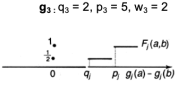

In [560]:
towns = df['Miasto']
df.drop(['Miasto'],axis=1,inplace=True)

In [561]:
num_variants = df.shape[0]
num_criteria = df.shape[1]

In [562]:
pi_array = np.zeros((num_variants, num_variants))

In [563]:
df.head(5)

,Czas dojazdu samochodem,Liczba ludności,Średnia temperatura w lipcu,Liczba deszczowych dni w lipcu,Zanieczyszczenia powietrza
0,-306.0,293413.0,19.5,-10.0,5.0
1,-118.0,337666.0,19.4,-9.0,5.0
2,-226.0,486022.0,18.9,-10.0,5.0
3,-57.0,546859.0,19.8,-9.0,5.0
4,-214.0,289162.0,19.5,-11.0,1.0


In [564]:
def calculate_g(v1, v2, q, p):
    if v1 >= v2 + p:
        return 1
    elif v1 >= v2 + q:
        return 1/2
    return 0

In [565]:
for a, row in df.iterrows():
    for b, candidate in df.iterrows():
        if a != b:
            pi = []
            for c in range(num_criteria):
                ai = df.iloc[a][c]
                bi = df.iloc[b][c]
                g = calculate_g(ai, bi, q[c], p[c])
                pi.append(g)
            pi_array[a,b] = sum([pi[i]*w[i] for i in range(len(pi))]) / sum(w)

In [566]:
pd.DataFrame(pi_array, index=towns, columns=towns)

Miasto,Białystok,Bydgoszcz,Gdańsk,Poznań,Katowice,Kielce,Kraków,Lublin,Łódź,Opole,Rzeszów,Warszawa,Wrocław,Zielona Góra
Miasto,,,,,,,,,,,,,,
Białystok,0.00,0.15,0.15,0.15,0.40,0.50,0.40,0.20,0.30,0.35,0.60,0.35,0.30,0.35
Bydgoszcz,0.45,0.00,0.45,0.15,0.60,0.80,0.60,0.40,0.40,0.55,0.90,0.55,0.30,0.35
Gdańsk,0.55,0.35,0.00,0.15,0.60,0.50,0.50,0.50,0.30,0.35,0.80,0.30,0.30,0.35
Poznań,0.65,0.55,0.55,0.00,0.80,0.80,0.60,0.60,0.60,0.65,0.90,0.55,0.40,0.55
Katowice,0.20,0.00,0.00,0.00,0.00,0.20,0.25,0.25,0.00,0.20,0.40,0.05,0.00,0.20
Kielce,0.20,0.00,0.00,0.00,0.25,0.00,0.25,0.15,0.00,0.10,0.30,0.05,0.15,0.10
Kraków,0.30,0.20,0.20,0.20,0.35,0.20,0.00,0.25,0.20,0.20,0.50,0.05,0.20,0.20
Lublin,0.25,0.15,0.25,0.15,0.40,0.60,0.40,0.00,0.40,0.45,0.90,0.30,0.30,0.35
Łódź,0.40,0.20,0.40,0.20,0.80,0.55,0.60,0.45,0.00,0.20,0.65,0.30,0.15,0.20


In [567]:
negative_flows = np.sum(pi_array, axis=0)
positive_flows = np.sum(pi_array, axis=1)
accum_flows = positive_flows - negative_flows

pi_array_ext = np.hstack((pi_array, negative_flows[:, np.newaxis], positive_flows[:, np.newaxis], accum_flows[:, np.newaxis]))
pi_array_ext_df = pd.DataFrame(pi_array_ext, index=towns, columns=np.append(towns, ['nflow', 'pflow', 'aflow']))
pi_array_ext_df

,Białystok,Bydgoszcz,Gdańsk,Poznań,Katowice,Kielce,Kraków,Lublin,Łódź,Opole,Rzeszów,Warszawa,Wrocław,Zielona Góra,nflow,pflow,aflow
Miasto,,,,,,,,,,,,,,,,,
Białystok,0.00,0.15,0.15,0.15,0.40,0.50,0.40,0.20,0.30,0.35,0.60,0.35,0.30,0.35,4.65,4.20,-0.45
Bydgoszcz,0.45,0.00,0.45,0.15,0.60,0.80,0.60,0.40,0.40,0.55,0.90,0.55,0.30,0.35,2.15,6.50,4.35
Gdańsk,0.55,0.35,0.00,0.15,0.60,0.50,0.50,0.50,0.30,0.35,0.80,0.30,0.30,0.35,3.70,5.55,1.85
Poznań,0.65,0.55,0.55,0.00,0.80,0.80,0.60,0.60,0.60,0.65,0.90,0.55,0.40,0.55,1.55,8.20,6.65
Katowice,0.20,0.00,0.00,0.00,0.00,0.20,0.25,0.25,0.00,0.20,0.40,0.05,0.00,0.20,6.85,1.75,-5.10
Kielce,0.20,0.00,0.00,0.00,0.25,0.00,0.25,0.15,0.00,0.10,0.30,0.05,0.15,0.10,6.70,1.55,-5.15
Kraków,0.30,0.20,0.20,0.20,0.35,0.20,0.00,0.25,0.20,0.20,0.50,0.05,0.20,0.20,6.35,3.05,-3.30
Lublin,0.25,0.15,0.25,0.15,0.40,0.60,0.40,0.00,0.40,0.45,0.90,0.30,0.30,0.35,4.35,4.90,0.55
Łódź,0.40,0.20,0.40,0.20,0.80,0.55,0.60,0.45,0.00,0.20,0.65,0.30,0.15,0.20,3.45,5.10,1.65


In [568]:
print(np.sum(accum_flows))

1.3322676295501878e-15


In [569]:
positive_flows

array([4.2 , 6.5 , 5.55, 8.2 , 1.75, 1.55, 3.05, 4.9 , 5.1 , 3.4 , 1.5 ,
       5.8 , 5.2 , 5.55])

In [570]:
def create_ranking(towns, flow, ascending=False):
    df = pd.DataFrame({'towns': towns, 'flow': flow})
    df['rank'] = df['flow'].rank(method='dense', ascending=ascending)
    df = df.sort_values('rank').set_index('rank')
    return df

In [571]:
p_df = create_ranking(towns, positive_flows, ascending=False)
p_df

,towns,flow
rank,,
1.0,Poznań,8.20
2.0,Bydgoszcz,6.50
3.0,Warszawa,5.80
4.0,Gdańsk,5.55
4.0,Zielona Góra,5.55
5.0,Wrocław,5.20
6.0,Łódź,5.10
7.0,Lublin,4.90
8.0,Białystok,4.20


In [572]:
n_df = create_ranking(towns, negative_flows, ascending=True)
n_df

,towns,flow
rank,,
1.0,Poznań,1.55
2.0,Bydgoszcz,2.15
3.0,Zielona Góra,3.15
4.0,Wrocław,3.20
5.0,Łódź,3.45
6.0,Warszawa,3.60
7.0,Gdańsk,3.70
8.0,Opole,4.10
9.0,Lublin,4.35


In [573]:
create_ranking(towns, accum_flows)

,towns,flow
rank,,
1.0,Poznań,6.65
2.0,Bydgoszcz,4.35
3.0,Zielona Góra,2.40
4.0,Warszawa,2.20
5.0,Wrocław,2.00
6.0,Gdańsk,1.85
7.0,Łódź,1.65
8.0,Lublin,0.55
9.0,Białystok,-0.45


In [574]:
def draw_simple_ranking(df, title):
    dot = gv.Digraph()
    for i in range(df.shape[0]):
        dot.node(df.iloc[i]['towns'])
        if i > 0:
            dot.edge(df.iloc[i-1]['towns'], df.iloc[i]['towns'], color='green')
    
    dot.render(f'{title}.gv', view=False)
        
def draw_ranking(vertices, preferrences, indiffrences, incomparabilities):
    dot = gv.Digraph()
    
    for V in vertices:
        dot.node(V)

    for A, preffered in preferrences.items():
        for B in preffered:
            dot.edge(A, B, color='green')
            
    dot.render('ranking.gv', view=False)

def check_A_is_preferred_over_B_children(A, B, preferrences):
    for C in preferrences[B]:
        check_A_is_preferred_over_B_children(B, C, preferrences)
        if C in preferrences[A]:
            preferrences[A].remove(C)
            check_A_is_preferred_over_B_children(A, C, preferrences)

def intersect_rankings(df):
    # Step 1: Each city is a vertex
    vertices = pi_array_ext_df.index
    
    preferrences = {}
    indiffrences = {}
    incomparabilities = {}
    
    
    for A in vertices:
        preferrences[A] = []
        indiffrences[A] = []
        incomparabilities[A] = []
        for B in vertices:
            if A == B:
                continue
            if df.loc[A, 'pflow'] > df.loc[B, 'pflow'] and df.loc[A, 'nflow'] < df.loc[B, 'nflow'] or df.loc[A, 'pflow'] >= df.loc[B, 'pflow'] and df.loc[A, 'nflow'] < df.loc[B, 'nflow'] or df.loc[A, 'pflow'] > df.loc[B, 'pflow'] and df.loc[A, 'nflow'] <= df.loc[B, 'nflow']:
                preferrences[A].append(B)
            elif df.loc[A, 'pflow'] == df.loc[B, 'pflow'] and df.loc[A, 'nflow'] == df.loc[B, 'nflow']:
                indiffrences[A].append(B)
            elif df.loc[A, 'pflow'] > df.loc[B, 'pflow'] and df.loc[A, 'nflow'] > df.loc[B, 'nflow'] or df.loc[A, 'pflow'] < df.loc[B, 'pflow'] and df.loc[A, 'nflow'] < df.loc[B, 'nflow']:
                incomparabilities[A].append(B)

            
    # TODO: check if this is correct
    
    for A in vertices:
        for B in preferrences[A]:
            check_A_is_preferred_over_B_children(A, B, preferrences)
                
    
    # for A, preffered in preferrences.items():
    #     print(f'{A} is preffered over {preffered}')
        
    # for A, indiff in indiffrences.items():
    #     print(f'{A} is indifferent to {indiff}')
        
    # for A, incom in incomparabilities.items():
    #     print(f'{A} is incomparable to {incom}')

    draw_ranking(vertices, preferrences, indiffrences, incomparabilities)
    
# intersect_rankings(pi_array_ext_df)

In [575]:
draw_simple_ranking(n_df, title='negative_flow_rank')
draw_simple_ranking(p_df, title='positive_flow_rank')

### ELECTRE III

In [576]:
df

,Czas dojazdu samochodem,Liczba ludności,Średnia temperatura w lipcu,Liczba deszczowych dni w lipcu,Zanieczyszczenia powietrza
0,-306.0,293413.0,19.5,-10.0,5.0
1,-118.0,337666.0,19.4,-9.0,5.0
2,-226.0,486022.0,18.9,-10.0,5.0
3,-57.0,546859.0,19.8,-9.0,5.0
4,-214.0,289162.0,19.5,-11.0,1.0
5,-246.0,192498.0,19.4,-10.0,2.0
6,-265.0,800653.0,19.5,-11.0,1.0
7,-285.0,334681.0,17.8,-9.0,5.0
8,-133.0,670642.0,19.5,-10.0,3.0
9,-159.0,127839.0,20.1,-10.0,4.0


In [577]:
# uzywamy tych samych charakterystki co dla PROMETHEE + dodajemy progi veto
v = [240, 500000, 5, 5, 4]
q, p, v, w

([30, 50000, 1, 1, 0],
 [60, 100000, 3, 3, 2],
 [240, 500000, 5, 5, 4],
 [2, 2, 1, 2, 3])

In [578]:
def g(variant, criterion):
    return df.loc[variant, criterion]

In [579]:
# marginal concordance for gain-type criterion
def get_Ci(a, b, qi, pi, vi, df, c):
    if g(a, c) - g(b, c) >= -qi:
        return 1
    if g(a, c) - g(b, c) < -pi:
        return 0
    return (pi - (g(b, c) - g(a, c))) / (pi - qi)

In [580]:
# marginal discordance for gain-type criterion
def get_Di(a, b, qi, pi, vi, c):
    if g(a, c) - g(b, c) <= -vi:
        return 1
    if g(a, c) - g(b, c) >= -pi:
        return 0
    return ((g(b, c) - g(a, c)) - pi) / (vi - pi)

In [581]:
Ci = np.zeros((df.shape[1], df.shape[0], df.shape[0]))
Di = np.zeros((df.shape[1], df.shape[0], df.shape[0]))

for crit, a, b in np.ndindex(Ci.shape):
    Ci[crit, a, b] = get_Ci(a, b, q[crit], p[crit], v[crit], df, df.columns[crit])
    Di[crit, a, b] = get_Di(a, b, q[crit], p[crit], v[crit], df.columns[crit])

In [582]:
C = np.array(sum([Ci[j]*w[j] for j in range(num_criteria)])) / sum(w)


$\sigma(a,b) = C(a,b) \prod_{i \in F} \frac{1-D_i(a,b)}{1 -C(a,b)} $ where $F=\{i: Di(a,b) > C(a,b)\}$

In [583]:
Di.shape, C.shape # ((5, 14, 14), (14, 14))

((5, 14, 14), (14, 14))

In [584]:
sigm = np.zeros_like(C)

for a, b in np.ndindex(sigm.shape):
    product = 1.0
    for crit in range(Di.shape[0]):
        if Di[crit, a, b] > C[a, b]:
            product *= (1 - Di[crit, a, b]) / (1 - C[a, b])
    sigm[a, b] = C[a, b] * product

In [585]:
for i in range(num_variants):
    print(sigm[i,i])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [586]:
Di_dfs = [pd.DataFrame(di) for di in Di]
Ci_dfs = [pd.DataFrame(ci) for ci in Ci]
C_df = pd.DataFrame(C)

In [587]:
Di_dfs[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.711111,0.111111,1.000000,0.177778,0.000000,0.000000,0.000000,0.627778,0.483333,0.0,0.333333,0.783333,0.622222
1,0.0,0.000000,0.000000,0.005556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0.266667,0.000000,0.605556,0.000000,0.000000,0.000000,0.000000,0.183333,0.038889,0.0,0.000000,0.338889,0.177778
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.200000,0.000000,0.538889,0.000000,0.000000,0.000000,0.000000,0.116667,0.000000,0.0,0.000000,0.272222,0.111111
5,0.0,0.377778,0.000000,0.716667,0.000000,0.000000,0.000000,0.000000,0.294444,0.150000,0.0,0.000000,0.450000,0.288889
6,0.0,0.483333,0.000000,0.822222,0.000000,0.000000,0.000000,0.000000,0.400000,0.255556,0.0,0.105556,0.555556,0.394444
7,0.0,0.594444,0.000000,0.933333,0.061111,0.000000,0.000000,0.000000,0.511111,0.366667,0.0,0.216667,0.666667,0.505556
8,0.0,0.000000,0.000000,0.088889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.233333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [588]:
sigm


array([[1.        , 0.8       , 0.6       , 0.        , 0.8       ,
        0.8       , 0.        , 1.        , 0.42841964, 0.8       ,
        1.        , 0.        , 0.24473312, 0.8       ],
       [1.        , 1.        , 0.8       , 0.6       , 1.        ,
        1.        , 0.37013   , 1.        , 0.8       , 1.        ,
        1.        , 0.        , 0.8       , 1.        ],
       [1.        , 0.8       , 1.        , 0.756652  , 1.        ,
        1.        , 0.8       , 1.        , 0.6       , 0.79      ,
        1.        , 0.        , 0.59      , 0.79      ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.8       , 1.        , 0.8       , 1.        ,
        1.        , 0.        , 0.8       , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.85      , 0.        , 0.        , 0.12698571, 0.53333333,
        0.7       , 0.        , 0.1564675 , 0.        ],
       [0.5       , 0.19047619, 0.5

In [589]:
import copy

In [590]:
def s(lambda_k, alpha=-0.15, beta=0.3):
    return alpha * lambda_k + beta


def desc_distilation(preorder, sigm_arr):
    k = 0
    sigm_df = pd.DataFrame(sigm_arr, index=towns, columns=towns)
    # wypełniamy przekątną macierzy nieskończonościami na potrzeby szukania maksimum
    np.fill_diagonal(sigm_arr, -np.inf)
    upper_credibility_threshold = np.max(sigm_arr)
    lower_credibility_threshold = np.max(sigm_arr[sigm_arr < upper_credibility_threshold - s(upper_credibility_threshold)])

    # jeśli współczynnik to zero, dodaj cały zbiór na dół rankingu STOP
    if upper_credibility_threshold == 0:
        # indexes of values that are not -inf
        return
    else:
        k += 1
        # wykreśl wartości niezgodne progiem
        for a in range(sigm_arr.shape[0]):
            for b in range(sigm_arr.shape[1]):
                #if sigm_arr[a, b] != -np.inf and sigm_arr[b,a] != -np.inf:
                if sigm_arr[a, b] < lower_credibility_threshold or sigm_arr[a, b] < sigm_arr[b, a] + s(sigm_arr[a, b]):
                    sigm_arr[a, b] = -np.inf
        # obliczamy siłę i słabość
        tmp = np.where(sigm_arr == -np.inf, 0, sigm_arr)
        strength = np.count_nonzero(tmp, axis=1)
        weakness = np.count_nonzero(tmp, axis=0)
        quality = strength - weakness
        sigma_df = pd.DataFrame(sigm_arr, index=towns, columns=towns)
        sigma_df['strength'] = strength
        sigma_df['weakness'] = weakness
        sigma_df['quality'] = quality
        max_quality = sigma_df['quality'].max()
        max_quality_alternatives = sigm_df[sigma_df['quality'] == max_quality]
        
        if len(max_quality_alternatives) == 1:
            alternative = max_quality_alternatives.index[0]
            alt_index = sigm_df.index.get_loc(alternative)
            preorder.append(alternative)
            print("Dodaję na dół rankingu: ", alternative)
            #wykreśl wariant z macierzy dodany do rankingu
            sigm_arr[alt_index, :] = -np.inf
            sigm_arr[:, alt_index] = -np.inf
        else:
            # destylacja wewnętrzna
            alt_indexes = [sigm_df.index.get_loc(alt) for alt in max_quality_alternatives.index]
            preorder.append(list(max_quality_alternatives.index))
            print("Dodaję na dół rankingu: ", list(max_quality_alternatives.index))
            for alt_index in alt_indexes:
                sigm_arr[alt_index, :] = -np.inf
                sigm_arr[:, alt_index] = -np.inf
                
        if np.all(sigm_arr == -np.inf):
            print("STOP")
            return preorder
        else:
            desc_distilation(preorder, sigm_arr)


        
        

In [591]:

preorder = []
desc_distilation(preorder, sigm)

# TODO: zadbać o zapiswanie tego w tablicy / kolejce
# TODO: naprawić wykreślanie - może coś się psuje przy kopiowaniu tablicy z funkcji do funkcji, idk

Dodaję na dół rankingu:  Poznań
Dodaję na dół rankingu:  Bydgoszcz
Dodaję na dół rankingu:  ['Gdańsk', 'Warszawa']
Dodaję na dół rankingu:  Łódź
Dodaję na dół rankingu:  ['Lublin', 'Wrocław', 'Zielona Góra']
Dodaję na dół rankingu:  ['Kraków', 'Opole']
Dodaję na dół rankingu:  Białystok
STOP


C:\Users\Mariusz\AppData\Local\Temp\ipykernel_26912\710290876.py:23: RuntimeWarning: invalid value encountered in scalar add
  if sigm_arr[a, b] < lower_credibility_threshold or sigm_arr[a, b] < sigm_arr[b, a] + s(sigm_arr[a, b]):
C:\Users\Mariusz\AppData\Local\Temp\ipykernel_26912\710290876.py:23: RuntimeWarning: invalid value encountered in scalar add
  if sigm_arr[a, b] < lower_credibility_threshold or sigm_arr[a, b] < sigm_arr[b, a] + s(sigm_arr[a, b]):
C:\Users\Mariusz\AppData\Local\Temp\ipykernel_26912\710290876.py:23: RuntimeWarning: invalid value encountered in scalar add
  if sigm_arr[a, b] < lower_credibility_threshold or sigm_arr[a, b] < sigm_arr[b, a] + s(sigm_arr[a, b]):
C:\Users\Mariusz\AppData\Local\Temp\ipykernel_26912\710290876.py:23: RuntimeWarning: invalid value encountered in scalar add
  if sigm_arr[a, b] < lower_credibility_threshold or sigm_arr[a, b] < sigm_arr[b, a] + s(sigm_arr[a, b]):
